In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
#from scipy.sparse import diags
#from numpy.linalg import solve

# Definition of constants and adimensional numbers

In [2]:
# Adimensional numbers and heat transfer coefficients definitions

beta = 5.57*10**(-4);
kinematic_viscosity = (4.06*10**(-4))/981.2;
vessel_height = 7;
p_in = 8.25*10**6;
rho_1 = 852.5;
rho_2 = 981.2;
mass_flow_rate = 3227;
Cp_1 = 4534;
mu_1 = 1.259*10**-4;
k_1 = 0.658;
mu_2 = 4.06*10**-4;
k_2 = 0.666;
Young_modulus = 177*10**9;
Poisson_coeff = 0.3;
Linear_expansion_coeff = 1.7*10**(-5);
k_vessel = 48.1;
mu_attenuation = 24;
Gamma_flux = 1.5*10**(13)*10000;    # Photons/(m^2*s)
Gamma_energy = 6*1.6*10**(-13);     # Joules
Buildup = 1.4;
p_design = 8.25*10**6;
p_2 = 7.5*10**6;
T_1 = 214+273.15;
T_2 = 70+273.15;
Cp_2 = 4172.5;
D_in = 3;
R_v_i = 1.5; 
sigma_yield = 165;
sigma_m = sigma_yield*2/3;
T_melt = 1450+273.15;
A_annulus = np.pi*((R_v_i)**2-(1.25)**2);
Inlet_speed = 3227/(852.5*A_annulus);


Reynolds = lambda rho, v, D, mu_viscosity : (rho*v*D)/mu_viscosity;
Dittus_boelter = lambda Re, Pr : 0.023*(Re**0.8)*(Pr**0.4);
Mc_Adams = lambda Gr, Pr: 0.13*((Gr*Pr)**(1/3));
Prandtl = lambda mu_viscosity, Cp, k: (mu_viscosity*Cp)/k;
Grashof = lambda beta, dT, L, nu : (9.81*beta*dT*(L**3))/(nu**2);   #dT = 30 kelvin
Max_thermal_stress = lambda sigma_T, alfa, E, q_V, k_vessel, nu, mu_attenuation: sigma_T*alfa*E*q_V/(k_vessel*(1-nu)*mu_attenuation**2);

h = lambda Nu, k_Water, diametre: Nu*k_Water/diametre;

thickness_min = (p_in)*(1.5)/((sigma_m*10**6)-(0.5*p_in));  #meters
thickness_real = thickness_min+thickness_min/10;
R_v_o = R_v_i + thickness_min;

# Adimensional numbers for case 1 - forced convection inside the vessel

Re_1 = Reynolds(rho_1, Inlet_speed, 0.5, mu_1);
Pr_1 = Prandtl(mu_1,Cp_1,k_1);
outer_D = 3 + thickness_real*2 + 0.05*2;
Nu_1 = Dittus_boelter(Re_1, Pr_1);
h1 = h(Nu_1, k_1, 0.5);


# Adimensional numbers for case 2 - natural convection outside the vessel

Gr_2 = Grashof(beta, 30, vessel_height, kinematic_viscosity);
Pr_2 = 4.06*10**-4*4172.5/0.666;
Nu_2 = Mc_Adams(Gr_2, Pr_2);
h2 = h(Nu_2, 0.666, vessel_height);

# Results

Re_1, Pr_1, Nu_1, h1, Gr_2, Pr_2, Nu_2, h2, kinematic_viscosity





(5933632.768951362,
 0.8675237082066869,
 5697.664968656181,
 7498.127098751535,
 328399577137755.1,
 2.543596096096096,
 12243.16207258415,
 1164.8494200487205,
 4.1377904606604154e-07)

## Thickness calculation using ASME criterion
We can compute the minimum thickness as:
\begin{equation}
t_{min} = \frac{p\cdot R_i}{\sigma_m-0.5p}
\end{equation}
Where $\sigma_m = 130MPa$, $p = 75\, bar$, $R_i = 1.5 m$

In [3]:
thickness_min = (p_in)*(R_v_i)/((sigma_m*10**6)-(0.5*p_in));  #meters
thickness_min, thickness_real

(0.11688311688311688, 0.12857142857142856)

# Buckling verification

## Buckling according to Corradi

In [4]:
q_E_fun = lambda Young_modulus, Poisson_coeff, external_D, thickness: 2*(Young_modulus/(1-Poisson_coeff**2))*1/((external_D/thickness)*(external_D/thickness -1)**2);
q_o_fun = lambda sigma_y, external_D, thickness: 2*sigma_y*thickness/external_D*(1+0.5*thickness/external_D);

'''
We evaluate the thickness by plugging the first guess (Mariotte) into the Corradi procedure,
then adjusting it retroactively in order to make the external pressure less then the allowable pressure

'''

thickness_real = thickness_min*1.1 + 0.0519234;

W = np.min([(2*R_v_i*1000+50)/(200)*(2*R_v_i*1000+1250)/200, 2*R_v_i*1000/100])/(2*R_v_i*1000);   # Maximum ovality allowed calculated as per ASME NB-4221.1
S_corr = 2;
q_c = p_2*S_corr;
critical_D_over_t = np.sqrt(Young_modulus/(sigma_yield*10**6*(1-Poisson_coeff**2)));
D_v_o = 2*(R_v_i+thickness_real);
q_E = q_E_fun(Young_modulus, Poisson_coeff, D_v_o, thickness_real);
q_o = q_o_fun(sigma_yield*10**6, D_v_o, thickness_real);
k = 1/(1-Poisson_coeff**2)*Young_modulus/(sigma_yield*10**6);
D_v_o/thickness_real, critical_D_over_t, W, thickness_real, k

(18.62097481542407,
 np.float64(34.3339653815457),
 np.float64(0.01),
 0.1804948285714286,
 1178.8211788211786)

In [5]:
z = np.sqrt(3)/4 * (2*D_v_o/thickness_real + 1) * W;
q_L = 0.5*(q_o + q_E*(1+z)-np.sqrt((q_o + q_E*(1+z))**2 - 4*q_o*q_E));
q_U = q_o/(np.sqrt(1+z**2));


if (q_o/q_E)>0.7:
    mu_buckling = 0;
else: 
    if (q_o/q_E)<=0.7 and (q_o/q_E)>=0.4:
        mu_buckling = 0.35*np.log(q_E/q_o)-0.125;
    else:
        mu_buckling = 0;


q_L, q_U, mu_buckling

(np.float64(15001007.208771892), np.float64(17953327.407567196), 0)

In [6]:
q_Corradi = mu_buckling*q_U + (1-mu_buckling)*q_L;
s_Corradi = 2;
q_allowable_Corradi = q_Corradi/2;
q_allowable_Corradi, p_2, p_2<q_allowable_Corradi

(np.float64(7500503.604385946), 7500000.0, np.True_)

# Overall heat transfer coefficient between the outer surface of the vessel and the CCP water

In [7]:
# overall heat exchange coefficient between the outer surface of the vessel and the containment water
R_vo = 1.5+thickness_real;
R_io = R_vo + 0.05;

Thermal_resistence = R_vo*np.log(R_io/R_vo)/(1.4) + R_vo/(h2*R_io);
U2 = 1/Thermal_resistence;
U2, Thermal_resistence

(np.float64(27.75698764792559), np.float64(0.036026964189492465))

# Volumetric heat generation in vessel with and without gamma heating

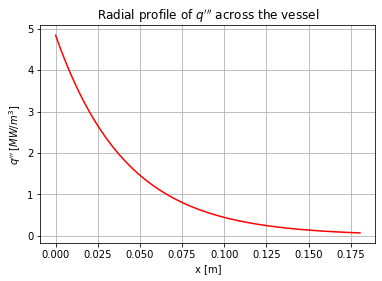

In [8]:
# volumetric heat generation in vessel due to gamma radiation

mu_attenuation = 24;  #1/meters
I0 = 1.4*6*1.602*10**(-13)*1.5*10**(13)*10000;
q0_V = I0*mu_attenuation;  #W/m3
x = np.linspace(0, thickness_real, 100);
q_V = I0*mu_attenuation*np.exp(-mu_attenuation*x);
plt.plot(x, q_V/1000000, color = "red");   # Q_V in MW/m3
plt.title("Radial profile of $q'''$ across the vessel");
plt.xlabel("x [m]");
plt.ylabel("$q''' \, [MW/m^3]$");
plt.grid();


In [9]:
# heat generation due to gamma in insulator

q0_V_insulator = q0_V*np.exp(-mu_attenuation*thickness_real);
q0_V_insulator, q0_V, I0

(np.float64(63669.94945892502), 4844447.999999999, 201851.99999999997)

## Temperature profile in the vessel with gamma heating

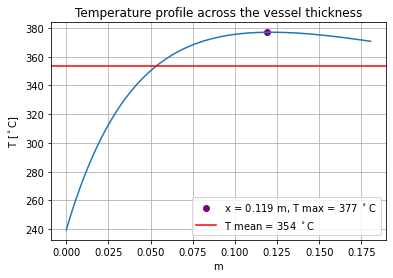

In [10]:
# analytical solution for Fourier equation in vessel witout thermal shield
def C1(T1, T2, q0_V, k_vessel, mu_attenuation, Lv, h1, u2):
    return ((q0_V/(k_vessel*mu_attenuation**2))*(np.exp(-mu_attenuation*Lv)-1)-(q0_V/mu_attenuation)*(1/h1 + np.exp(-mu_attenuation*Lv)/u2)-(T1-T2))/(Lv + k_vessel/h1 + k_vessel/u2)

def C2(T1, q0_V, h1, mu_attenuation, C1, k_vessel):
    return  T1 + q0_V/(h1*mu_attenuation) + C1*k_vessel/h1 + q0_V/(k_vessel*mu_attenuation**2);

def T(T1, T2, Lv, h1, u2, x, q_V, mu_attenuation, k_vessel):
    return -q_V/(k_vessel*mu_attenuation**2)*np.exp(-mu_attenuation*x) + C1(T1, T2, q_V, k_vessel, mu_attenuation, Lv, h1, u2)*x + C2(T1, q_V, h1, mu_attenuation, C1(T1, T2, q_V, k_vessel, mu_attenuation, Lv, h1, u2), k_vessel);

def T_mean_fun(q0_V, k_vessel, mu_attenuation, c1, c2, Lv):
    return q0_V/(k_vessel*mu_attenuation**2)*(np.exp(-mu_attenuation*Lv)-1)/(mu_attenuation*Lv) + (c1*Lv)/2 + c2;

Lv = thickness_real;
T1 = T_1;      # Supposing core inlet temperature does not vary in the downcomer and is not influenced by the heat generation in the core
T2 = T_2;
mu_attenuation = 24;
k_vessel = 48.1;
c1 = C1(T1, T2, q0_V, k_vessel, mu_attenuation, Lv, h1, U2);
c2 = C2(T1, q0_V, h1, mu_attenuation, c1, k_vessel);

T_mean = T_mean_fun(q0_V, k_vessel, mu_attenuation, c1, c2, Lv);

x = np.linspace(0, Lv, 100);
T_actual = np.zeros(100);

for i in range (100):
    T_actual[i] = T(T1, T2, Lv, h1, U2, x[i], q0_V, mu_attenuation, k_vessel);   # in Kelvin
    T_actual[i] = T_actual[i]-273.15;   # in Celsius

plt.plot(x, T_actual);
plt.grid();
plt.title("Temperature profile across the vessel thickness");
plt.xlabel("m");
plt.scatter(np.argmax(T_actual)*Lv/100, np.max(T_actual), color = "purple", label = f"x = {np.argmax(T_actual)*Lv/100:.3g} m, T max = {np.max(T_actual):.3g} $^\circ$C");
plt.ylabel("T [$^\circ$C]");
plt.axhline(T_mean-273.15, color = "red", label = "T mean = {:.3g} $^\circ$C".format(T_mean-273.15));
plt.legend();



In [11]:
T_design = T_mean + 20;
T_mean-273.15, T_design-273.15   # T in celsius

(np.float64(353.8343467174693), np.float64(373.8343467174693))

In [12]:
# finding the maximum temperature in the vessel
max_T = np.max(T_actual);


# position of maximum T in the vessel
x_max = np.argmax(T_actual)*Lv/100;
x_max, max_T, (max_T+273.15)/T_melt

(np.float64(0.11912658685714288),
 np.float64(377.0506804215846),
 np.float64(0.3773326062278876))

Thus we have creep, and we cannot conduct the stress analysis since the rules for creep behaviour are too complex

## Tmperature profile in vessel without gamma heating

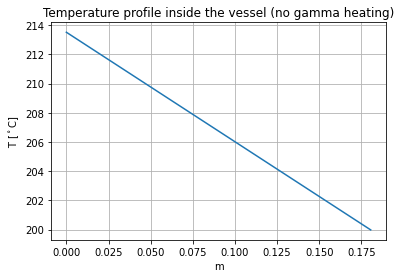

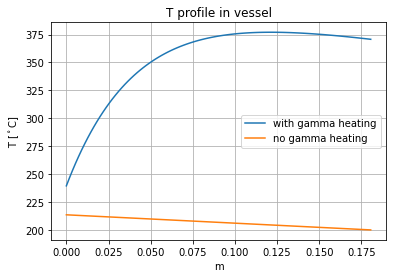

In [13]:
# temperature profile in vessel without gamma heat generation

T_no_gamma = np.zeros(100);
for i in range (100):
    T_no_gamma[i] = T(T1, T2, Lv, h1, U2, x[i], 0, mu_attenuation, k_vessel);   # in Kelvin
    T_no_gamma[i] = T_no_gamma[i]-273.15;   # in Celsius

plt.plot(x, T_no_gamma);
plt.grid();
plt.title("Temperature profile inside the vessel (no gamma heating)")
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show();
plt.plot(x, T_actual, label = "with gamma heating");
plt.plot(x, T_no_gamma, label = "no gamma heating");
plt.legend();
plt.grid();
plt.title("T profile in vessel");
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show()

In [14]:
# thermal power flux with no gamma heating

q_no_gamma = -k_vessel*(T_no_gamma[99]-T_no_gamma[0])/thickness_real;
q_no_gamma

np.float64(3607.8631514234207)

In [15]:
T_no_gamma[0]

np.float64(213.51883142231287)

## Stress analysis in the vessel

We separate the thermal and mechanical problems since we are in the thermoelastic regime. The geometry of the problem is cylindrical, and we can assume axial symmetry and orthocylindricity. The cylinder can be approximated as thin since:

In [16]:
2*R_v_o/thickness_real, 7/(2*R_v_o)

(17.91611571013244, 2.164658634538153)

In [17]:
sigma_r_mariotte = -p_design/(2*10**6);
sigma_theta_mariotte = R_v_i*p_design/(10**6*thickness_real);
sigma_zeta_mariotte = sigma_theta_mariotte/2;
#sigma_zeta_mariotte = 0;
sigma_r_mariotte, sigma_theta_mariotte, sigma_zeta_mariotte

(-4.125, 68.5615211136243, 34.28076055681215)

In [18]:
np.max([sigma_r_mariotte, sigma_theta_mariotte, sigma_zeta_mariotte]) < sigma_m

np.True_

However, since in normal operations we expect to have a different pressure on the outer and inner diameter we use Lamé theory for the mechanical stresses. We can assume plane strain solution since we want to avoid the vessel expanding along the z direction.

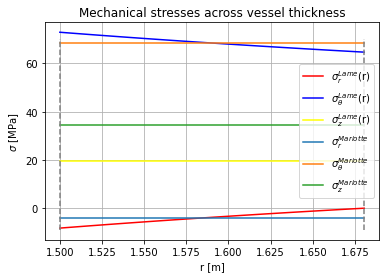

In [19]:
sigma_r_fun = lambda a, b, p_in, p_out, r: -(a*b)**2/(b**2-a**2)*(p_in-p_out)/r**2 + (a**2*p_in - b**2*p_out)/(b**2-a**2);
sigma_theta_fun = lambda a, b, p_in, p_out, r : (a**2*p_in-b**2*p_out)/(b**2-a**2) + (a*b)**2/(b**2-a**2)*(p_in-p_out)/r**2;

r =np.linspace(R_v_i, R_v_i+thickness_real, 100);
sigma_r = np.zeros(100);
sigma_theta = np.zeros(100);
for i in range (100):
    sigma_r[i] = sigma_r_fun(R_v_i, R_v_i+thickness_real, p_design/(10**6), 0, r[i]);
    sigma_theta[i] = sigma_theta_fun(R_v_i, R_v_i+thickness_real, p_design/(10**6), 0, r[i]);

#sigma_z_value = 2*Poisson_coeff*((R_v_i**2*p_design-R_v_o**2*p_2)/(R_v_o**2-R_v_i**2));
sigma_z = np.zeros(100);
for i in range(100):
    sigma_z[i] = Poisson_coeff*(sigma_r[i] + sigma_theta[i]);
    #sigma_z[i] = 0;

plt.plot(r, sigma_r, color = "red", label = "$\sigma_r^{Lame}$(r)");
plt.plot(r, sigma_theta, color = "blue", label = "$\sigma_{\\theta}^{Lame}$(r)");
plt.plot(r, sigma_z, color = "yellow", label = "$\sigma_z^{Lame}$(r)");
plt.plot(r, sigma_r_mariotte*np.ones(100),label = "$\sigma_r^{Mariotte}$");
plt.plot(r, sigma_theta_mariotte*np.ones(100), label = "$\sigma_{\\theta}^{Mariotte}$");
plt.plot(r, sigma_zeta_mariotte*np.ones(100), label = "$\sigma_z^{Mariotte}$");
plt.grid();
plt.legend();
plt.title("Mechanical stresses across vessel thickness");
plt.xlabel("r [m]");
plt.ylabel("$\sigma$ [MPa]");
plt.vlines([R_v_i, R_v_i+thickness_real], -9, 70, linestyles="dashed", color = "grey");
plt.show()

In [20]:
sigma_theta_gradient = sigma_theta - sigma_theta_mariotte
sigma_r_gradient = sigma_r - sigma_r_mariotte
sigma_zeta_gradient = sigma_z - sigma_zeta_mariotte;
sigma_zeta_gradient_max = sigma_zeta_gradient[0];
sigma_r_gradient_max = sigma_r_gradient[0];
sigma_theta_gradient_max = sigma_theta_gradient[0];
sigma_theta_gradient_max


np.float64(4.359096015867976)

In [21]:
# Stress tensor
sigma_mech_tensor = np.diag([sigma_r, sigma_theta, sigma_z]);

In [22]:
# Maximum hoop thermal stress along the vessel thickness

Radius_ratio = (R_v_i+thickness_real)/R_v_i;
design_parametre = mu_attenuation*R_v_i;
sigma_T = 0.68;

sigma_theta_thermal_max = Max_thermal_stress(sigma_T, Linear_expansion_coeff, Young_modulus, q0_V, k_vessel, Poisson_coeff, mu_attenuation);
sigma_theta_thermal_max=sigma_theta_thermal_max/10**6
sigma_z_thermal_max = sigma_theta_thermal_max;
sigma_theta_thermal_max, sigma_theta[0]


(511.1046112266112, np.float64(72.92061712949227))

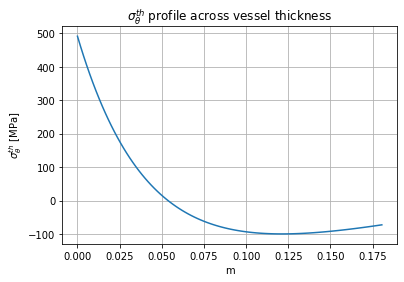

In [23]:
# actual thermal stress along the vessel

sigma_theta_thermal = np.zeros(100);
sigma_r_thermal = np.zeros(100);
for i in range(100):
    sigma_theta_thermal[i] = Linear_expansion_coeff*Young_modulus/(1-Poisson_coeff)*((T_mean-273.15)-T_actual[i]);
    sigma_theta_thermal[i] = sigma_theta_thermal[i]/10**6;

plt.plot(np.linspace(0, thickness_real, 100), sigma_theta_thermal);
plt.grid();
plt.title("$\\sigma_{\\theta}^{th}$ profile across vessel thickness");
plt.xlabel("m");
plt.ylabel("$\\sigma_{\\theta}^{th}$ [MPa]");


In [24]:
# maximum hoop thermal stress calculated precisely

np.max(sigma_theta_thermal)

np.float64(491.67531843948547)

In [25]:
# comparison stress accordong to tresca
sigma_total = [sigma_r_gradient_max, sigma_theta_gradient_max + sigma_theta_thermal_max, sigma_zeta_gradient_max+sigma_z_thermal_max];
sigma_c = np.max([abs(sigma_total[0]-sigma_total[1]), abs(sigma_total[1]-sigma_total[2]), abs(sigma_total[2]-sigma_total[0])]);
sigma_total, sigma_c, sigma_c < 3*sigma_m

([np.float64(-4.125),
  np.float64(515.4637072424791),
  np.float64(496.22503580864674)],
 np.float64(519.5887072424791),
 np.False_)

The thermal stress is too high and the shell will yield without a thermal shield

# Thermal shield

In [26]:
sigma_theta_thermal_max = 3*sigma_m+sigma_total[0]-sigma_theta_gradient_max
sigma_theta_thermal_max

np.float64(321.515903984132)

In [27]:
q0_V_allowable = sigma_theta_thermal_max*10**6*k_vessel*(1-Poisson_coeff)*mu_attenuation**2/(sigma_T*Linear_expansion_coeff*Young_modulus);
q0_V_allowable   #W/m**3

np.float64(3047452.60326664)

Since:
\begin{equation}
    q'''(x) = q_0'''e^{-\mu x}
\end{equation}
then the minimum thickness of the thermal shield is calculated as:
\begin{equation}
    s = -\frac{1}{\mu}\text{ln}\left(\frac{q_{allowable}'''}{q_0'''}\right)
\end{equation}

In [58]:
# minimum thickness calculation for the thermal shield
s_min = -1/mu_attenuation*np.log(q0_V_allowable/q0_V);
s_min = s_min*3.4;
s_min

np.float64(0.06566636429433376)

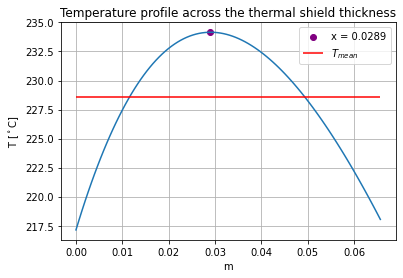

In [59]:
offset = 0;
Shield_center = (R_v_i-1.25)/2 + 1.25 + offset;
R_s_i = Shield_center-s_min/2;
R_s_o = R_s_i+s_min;
Re_1_shield = Reynolds(rho_1, Inlet_speed, 2*R_s_i-2.5, mu_1);
Pr_1_shield = Prandtl(mu_1, Cp_1, k_1);
Nu_1_shield = Dittus_boelter(Re_1, Pr_1);
h1_shield = h(Nu_1_shield, k_1, 2*R_s_i-2.5);

Re_2_shield = Reynolds(rho_1, Inlet_speed, 2*R_v_i-2*R_s_o, mu_1);
Pr_2_shield = Prandtl(mu_1, Cp_1, k_1);
Nu_2_shield = Dittus_boelter(Re_2_shield, Pr_2_shield);
h2_shield = h(Nu_2_shield, k_1, 2*R_v_i-2*R_s_o)


x_shield = np.linspace(0, s_min, 100);
T_shield = np.zeros(100);
for i in range (100):
    T_shield[i] = T(T1, T1, s_min, h1_shield, h2_shield, x_shield[i], q0_V_allowable, mu_attenuation, k_vessel)-273.15;

T_mean_thermal_shield = T_mean_fun(q0_V_allowable, k_vessel, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), C2(T1, q0_V_allowable, h1_shield, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), k_vessel), s_min);
T_mean_thermal_shield = T_mean_thermal_shield-273.15;


plt.plot(x_shield, T_shield);
plt.scatter(np.argmax(T_shield)*s_min/100, np.max(T_shield), color = "purple", label = f"x = {np.argmax(T_shield)*s_min/100:.3g}");
plt.hlines(T_mean_thermal_shield, 0, s_min, color = "red", label ="$T_{mean}$" );
plt.legend();
plt.grid();
plt.title("Temperature profile across the thermal shield thickness");
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show();

In [60]:
T_max_shield = np.max(T_shield);
T_max_shield, R_s_i, R_s_o

(np.float64(234.15678177698686),
 np.float64(1.3421668178528332),
 np.float64(1.407833182147167))

## Stress evaluation in the thermal shield

Mechanical stresses in the thrmal shield are null since internal pressure is equal to external pressure and even in case of accident the pressure would be equal on both sides

In [61]:
T_mean_thermal_shield = T_mean_fun(q0_V_allowable, k_vessel, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), C2(T1, q0_V_allowable, h1_shield, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), k_vessel), s_min);
T_mean_thermal_shield = T_mean_thermal_shield-273.15;
T_mean_thermal_shield

np.float64(228.59736052534367)

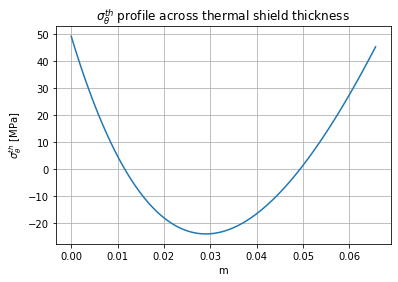

In [62]:
sigma_theta_thermal_thermal_shield = np.zeros(100);
for i in range(100):
    sigma_theta_thermal_thermal_shield[i] = Linear_expansion_coeff*Young_modulus/(1-Poisson_coeff)*((T_mean_thermal_shield)-T_shield[i]);
    sigma_theta_thermal_thermal_shield[i] = sigma_theta_thermal_thermal_shield[i]/10**6;

plt.plot(x_shield, sigma_theta_thermal_thermal_shield);
plt.grid();
plt.title("$\\sigma_{\\theta}^{th}$ profile across thermal shield thickness");
plt.xlabel("m");
plt.ylabel("$\\sigma_{\\theta}^{th}$ [MPa]");

Since the thermal stress along r is null at the borders since there are no constraints and $\sigma_z = \sigma_{\theta} + \sigma_r$, we have that the maximum stress is found at the borders where it is equal to $\sigma_{\theta}$
In terms of mechanical stresses, we cannot use Mariotte since the inner and outer pressures are equal, so we use Lamé and add it to the thermal stresses

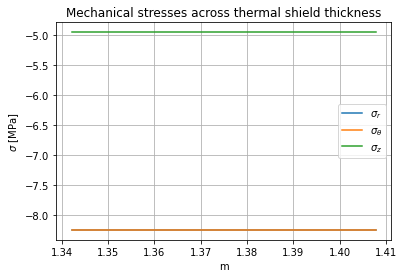

In [63]:
sigma_r_lame_thermal_shield = sigma_r_fun(R_s_i, R_s_o, p_design, p_design, np.linspace(R_s_i, R_s_o, 100));
sigma_theta_lame_thermal_shield = sigma_theta_fun(R_s_i, R_s_o, p_design, p_design, np.linspace(R_s_i, R_s_o, 100));
sigma_zeta_lame_thermal_shield = np.zeros(100);

for i in range(100):
    sigma_r_lame_thermal_shield[i] = sigma_r_lame_thermal_shield[i]/10**6;
    sigma_theta_lame_thermal_shield[i] = sigma_theta_lame_thermal_shield[i]/10**6;
    sigma_zeta_lame_thermal_shield[i] = Poisson_coeff*(sigma_r_lame_thermal_shield[i] + sigma_theta_lame_thermal_shield[i]);

plt.plot(np.linspace(R_s_i, R_s_o, 100), sigma_r_lame_thermal_shield);
plt.plot(np.linspace(R_s_i, R_s_o, 100), sigma_theta_lame_thermal_shield);
plt.plot(np.linspace(R_s_i, R_s_o, 100), sigma_zeta_lame_thermal_shield);
plt.grid();
plt.title("Mechanical stresses across thermal shield thickness");
plt.xlabel("m");
plt.ylabel("$\sigma$ [MPa]");
plt.legend(["$\sigma_r$", "$\sigma_{\\theta}$", "$\sigma_z$"]);
plt.show()

In [64]:
np.max(sigma_zeta_lame_thermal_shield), np.max(sigma_theta_lame_thermal_shield), np.max(sigma_r_lame_thermal_shield)

(np.float64(-4.9499999999999975),
 np.float64(-8.249999999999996),
 np.float64(-8.249999999999996))

In [65]:
np.max(sigma_theta_thermal_thermal_shield)

np.float64(49.27760736217037)

In [66]:
sigma_total_thermal_shield = [sigma_r_lame_thermal_shield[0], sigma_theta_lame_thermal_shield[0] + np.max(sigma_theta_thermal_thermal_shield), sigma_zeta_lame_thermal_shield[0]+np.max(sigma_theta_thermal_thermal_shield)];
sigma_c_thermal_shield = np.max([abs(sigma_total_thermal_shield[0]-sigma_total_thermal_shield[1]), abs(sigma_total_thermal_shield[1]-sigma_total_thermal_shield[2]), abs(sigma_total_thermal_shield[2]-sigma_total_thermal_shield[0])]);
sigma_c_thermal_shield, sigma_total_thermal_shield

(np.float64(52.57760736217037),
 [np.float64(-8.249999999999996),
  np.float64(41.02760736217037),
  np.float64(44.327607362170376)])

The stress conditions are allowable, since primary stresses are absent and secondary stresses are well below $\sigma_m$

# Recalculation of heat exchange with the presence of thermal shield

Temperature profile in the vessel with the presence of the thermal shield

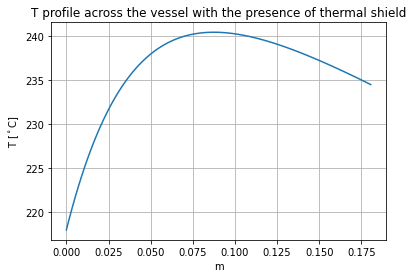

In [67]:
Re_1_with_shield = Reynolds(rho_1, Inlet_speed, 2*R_v_i-2*R_s_o, mu_1);
Pr_1_with_shield = Prandtl(mu_1, Cp_1, k_1);
Nu_1_with_shield = Dittus_boelter(Re_1_with_shield, Pr_1_with_shield);
h1_with_shield = h(Nu_1_with_shield, k_1, 2*R_v_i-2*R_s_o);

q0_V_with_shield = q0_V*np.exp(-mu_attenuation*s_min);

c1_with_shield = C1(T_1, T_2, q0_V_with_shield, k_vessel, mu_attenuation, thickness_real, h1_with_shield, U2);
c2_with_shield = C2(T_1, q0_V_with_shield, h1_with_shield, mu_attenuation, c1_with_shield, k_vessel);

T_with_shield = T(T_1, T_2, thickness_real, h1_with_shield, U2, np.linspace(0, thickness_real, 100), q0_V_with_shield, mu_attenuation, k_vessel)-273.15;
plt.plot(np.linspace(0, thickness_real, 100), T_with_shield);
plt.grid(); 
plt.title("T profile across the vessel with the presence of thermal shield");
plt.xlabel("m");
plt.ylabel("T [$^\circ $C]");

In [73]:
T_max_with_shield = np.max(T_with_shield)+273.15
T_max_with_shield/(1450+273.15), T_max_with_shield-273.15

(np.float64(0.2980469403824862), np.float64(240.42958532008117))

## Stress verification in the vessel with thermal shield

Actual thermal stress across the vessel

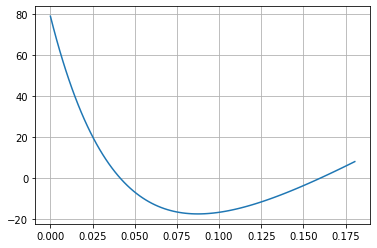

In [74]:
T_mean_with_sh = T_mean_fun(q0_V_with_shield, k_vessel, mu_attenuation, c1_with_shield, c2_with_shield, thickness_real)-273.15;

sigma_theta_thermal_with_sh = Linear_expansion_coeff*Young_modulus/(1-Poisson_coeff)*(T_mean_with_sh-T_with_shield)/10**6;

plt.plot(np.linspace(0, thickness_real, 100), sigma_theta_thermal_with_sh);
plt.grid();

Max (conservative) hoop thermal stress across the vessel

In [75]:
sigma_theta_thermal_max_with_sh = Max_thermal_stress(sigma_T, Linear_expansion_coeff, Young_modulus, q0_V_with_shield, k_vessel, Poisson_coeff, mu_attenuation)/10**6;
sigma_theta_thermal_max_with_sh

np.float64(105.69753214040854)

Stress verification on vessel with thermal shield

In [76]:
sigma_total_with_shield = [sigma_r_gradient_max, sigma_theta_gradient_max+sigma_theta_thermal_max_with_sh, sigma_zeta_gradient_max + sigma_theta_thermal_max_with_sh];
sigma_c_with_shield = np.max([np.abs(sigma_total_with_shield[0]-sigma_total_with_shield[1]), np.abs(sigma_total_with_shield[0]-sigma_total_with_shield[2]), np.abs(sigma_total_with_shield[1]-sigma_total_with_shield[2])]);
sigma_c_with_shield, sigma_total_with_shield, sigma_c_with_shield < 3*sigma_m

(np.float64(114.18162815627652),
 [np.float64(-4.125),
  np.float64(110.05662815627652),
  np.float64(90.81795672244408)],
 np.True_)

# Buckling for the vessel (don't know if we use ASME III or corradi)

In [77]:
# slenderness ratio

D_v_o = 2*R_v_i + 2*thickness_real;
k = 1/(1-Poisson_coeff**2)*Young_modulus/(sigma_yield*10**6);
slenderness = 1/np.sqrt(k)*(D_v_o/thickness_real);
slenderness, thickness_real

(np.float64(0.5423485055831253), 0.1804948285714286)